## **Importing libraries and datasets**

In [54]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [55]:
%cd '/content/drive/MyDrive/CRM/'
%ls

/content/drive/MyDrive/CRM
'Customer Survey.xlsx'   Retail_Data_Response.csv
 K2D-Regular.ttf         Retail_Data_Transactions.csv


In [56]:
filename1 = 'Retail_Data_Response.csv'
filename2 = 'Retail_Data_Transactions.csv'

df_response = pd.read_csv(filename1)
df_transactions = pd.read_csv(filename2, parse_dates=['trans_date'])

In [57]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [58]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [59]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


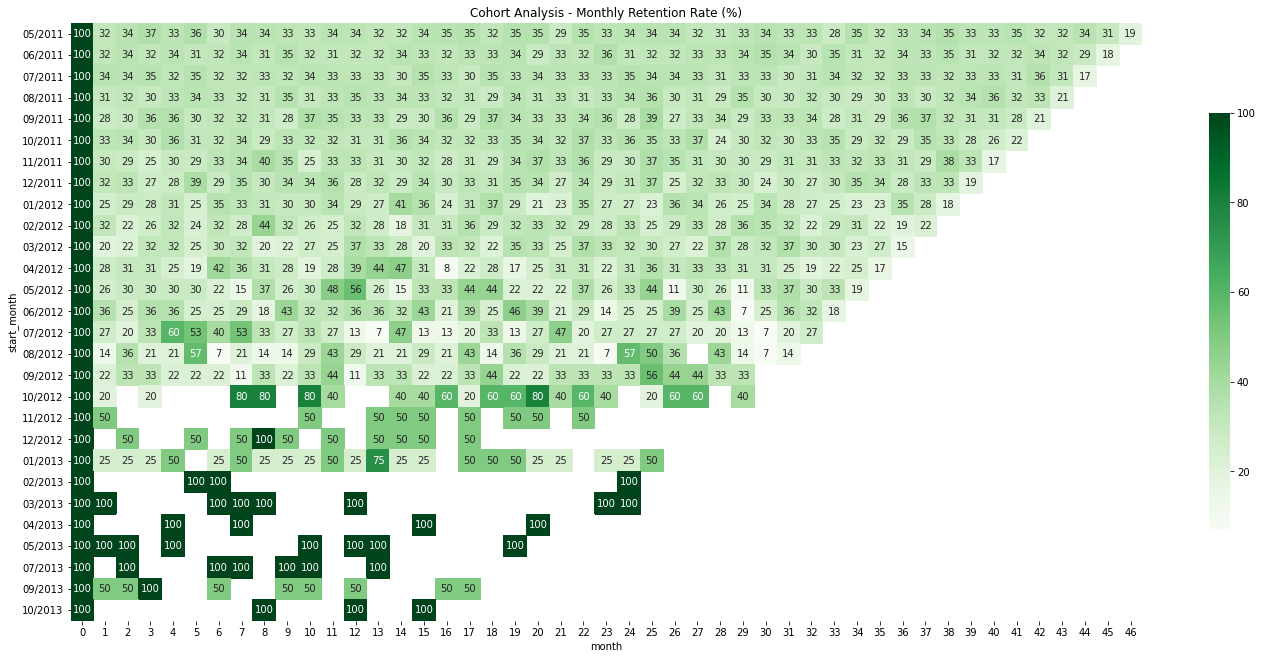

In [60]:
cohort = df_transactions.groupby(['customer_id', pd.Grouper(key='trans_date',freq='M')]).size().reset_index()
cohort['start_month'] = cohort['customer_id'].map(cohort.groupby('customer_id')['trans_date'].min())
cohort['month'] = cohort.apply(lambda x: (x['trans_date'].year - x['start_month'].year)*12 + (x['trans_date'].month - x['start_month'].month) , axis=1)
cohort = pd.pivot_table(cohort, index='start_month', columns='month', values='customer_id', aggfunc='count').sort_index()
cohort = cohort.divide(cohort.iloc[:,0], axis=0).multiply(100)
cohort.index = cohort.index.strftime('%m/%Y')
plt.figure(figsize=(24,11))
sns.heatmap(cohort, cmap='Greens', annot=True, fmt='.0f', cbar_kws={'shrink':.7})
# plt.yticks(cohort.index.strftime('%m/%Y'))
plt.title('Cohort Analysis - Monthly Retention Rate (%)');

## **Data Preparation**

In [61]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions=df_transactions[df_transactions['recent'] < 730] #Only the transactions made in the last 2 years are considered for analysis.
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
9,CS3802,2013-08-20,75,574.0


In [62]:
df_rfm = df_transactions.groupby('customer_id').agg(
        recency=('recent', min),                       
        frequency=('customer_id', len),                  
        monetary_value=('tran_amount', sum), 
        tenure=('recent', max),
        length_of_stay=('recent', lambda x: x.max() - x.min()),
     )

In [63]:
df_rfm

,recency,frequency,monetary_value,tenure,length_of_stay
customer_id,,,,,
CS1112,62.0,6,358,624.0,562.0
CS1113,36.0,11,775,696.0,660.0
CS1114,33.0,11,804,659.0,626.0
CS1115,12.0,11,831,727.0,715.0
CS1116,204.0,5,333,403.0,199.0
...,...,...,...,...,...
CS8996,98.0,7,369,475.0,377.0
CS8997,262.0,6,246,654.0,392.0
CS8998,85.0,5,205,676.0,591.0


In [64]:
## create data set with RFM variables
"""
df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

df_rfm = df_transactions.groupby('customer_id').agg({'recent': [lambda x:x.min(),lambda x:x.max(),lambda x: x.max() - x.min()],                     
                                                     'customer_id': lambda x: len(x),                
                                                     'tran_amount': lambda x: x.sum()}) 
df_rfm.rename(columns={'<lambda_0>': 'recency',
                        <lambda_1>': 'recency',
                        <lambda_0>': 'recency',
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value',
                       'tenure':'tenure',
                       'length_of_stay':'length_of_stay'}, inplace=True)
                       """

"\ndf_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency\n                                                     'customer_id': lambda x: len(x),                 # Frequency\n                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value\n\ndf_rfm.rename(columns={'recent': 'recency', \n                         'customer_id': 'frequency', \n                         'tran_amount': 'monetary_value'}, inplace=True)\n\ndf_rfm = df_transactions.groupby('customer_id').agg({'recent': [lambda x:x.min(),lambda x:x.max(),lambda x: x.max() - x.min()],                     \n                                                     'customer_id': lambda x: len(x),                \n                                                     'tran_amount': lambda x: x.sum()}) \ndf_rfm.rename(columns={'<lambda_0>': 'recency',\n                        <lambda_1>': 'recency',\n                        <lambda_0>': 'recen

In [65]:
df_rfm

,recency,frequency,monetary_value,tenure,length_of_stay
customer_id,,,,,
CS1112,62.0,6,358,624.0,562.0
CS1113,36.0,11,775,696.0,660.0
CS1114,33.0,11,804,659.0,626.0
CS1115,12.0,11,831,727.0,715.0
CS1116,204.0,5,333,403.0,199.0
...,...,...,...,...,...
CS8996,98.0,7,369,475.0,377.0
CS8997,262.0,6,246,654.0,392.0
CS8998,85.0,5,205,676.0,591.0


In [66]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,tenure,length_of_stay
0,CS1112,62.0,6,358,624.0,562.0
1,CS1113,36.0,11,775,696.0,660.0
2,CS1114,33.0,11,804,659.0,626.0
3,CS1115,12.0,11,831,727.0,715.0
4,CS1116,204.0,5,333,403.0,199.0


## **Calculating response rate**

In [67]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


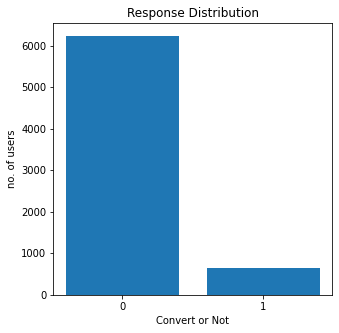

In [68]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [69]:
## merging two data sets

df_modeling = pd.merge(df_rfm,df_response)
df_modeling.head()

,customer_id,recency,frequency,monetary_value,tenure,length_of_stay,response
0,CS1112,62.0,6,358,624.0,562.0,0
1,CS1113,36.0,11,775,696.0,660.0,0
2,CS1114,33.0,11,804,659.0,626.0,1
3,CS1115,12.0,11,831,727.0,715.0,1
4,CS1116,204.0,5,333,403.0,199.0,1


## **Creating train and test dataset**

In [70]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 5)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 5)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

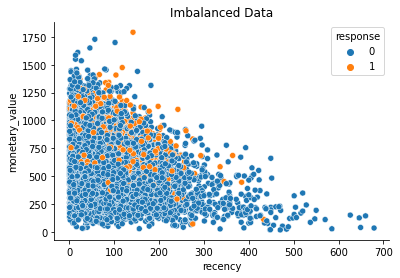

In [72]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

In [73]:
X_train

,recency,frequency,monetary_value,tenure,length_of_stay
6590,115.0,5,232,581.0,466.0
567,8.0,14,895,617.0,609.0
2468,425.0,4,370,687.0,262.0
1149,249.0,7,428,599.0,350.0
2752,139.0,13,972,654.0,515.0
...,...,...,...,...,...
4931,31.0,11,747,625.0,594.0
3264,152.0,11,732,699.0,547.0
1653,13.0,17,1144,724.0,711.0
2607,7.0,7,548,475.0,468.0


## **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

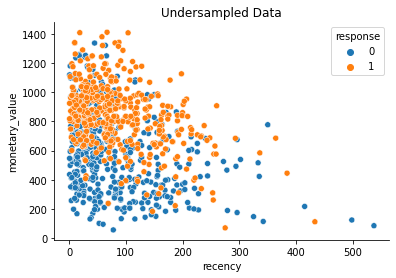

In [74]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value','tenure','length_of_stay', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

In [75]:
X_undersampled

array([[190.,   8., 364., 591., 401.],
       [226.,   9., 591., 669., 443.],
       [ 30.,   8., 571., 575., 545.],
       ...,
       [ 73.,  10., 749., 727., 654.],
       [118.,  11., 740., 713., 595.],
       [233.,   4., 339., 724., 491.]])

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

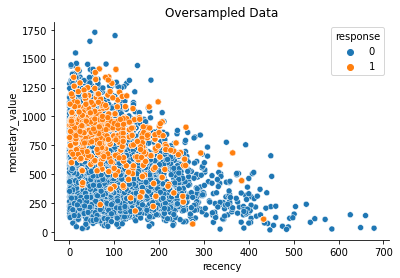

In [76]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value','tenure','length_of_stay', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

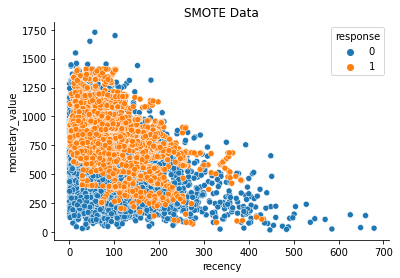

In [77]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value','tenure','length_of_stay', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [78]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       429
           1       0.71      0.77      0.74       429

    accuracy                           0.73       858
   macro avg       0.73      0.73      0.73       858
weighted avg       0.73      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.23      0.78      0.35       218

    accuracy                           0.70      2066
   macro avg       0.60      0.73      0.58      2066
weighted avg       0.89      0.70      0.75      2066



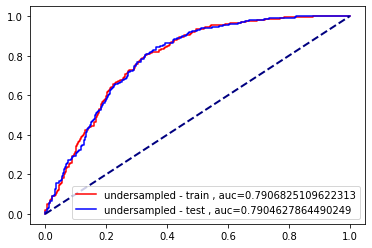

In [79]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [80]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.00366244  0.04585343  0.00404813  0.00129664 -0.0023658 ]] [-3.1418781]


In [81]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      4389
           1       0.71      0.73      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.23      0.77      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.73      0.58      2066
weighted avg       0.88      0.70      0.75      2066



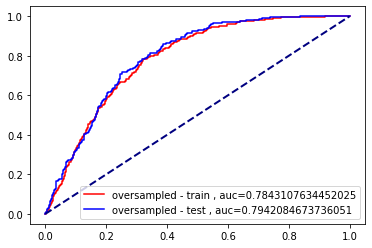

In [82]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [83]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 0.00458317  0.12807185  0.00312528  0.00242671 -0.00215646]] [-3.1418781]


In [84]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      4389
           1       0.72      0.75      0.73      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1848
           1       0.23      0.76      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.73      0.58      2066
weighted avg       0.88      0.70      0.76      2066



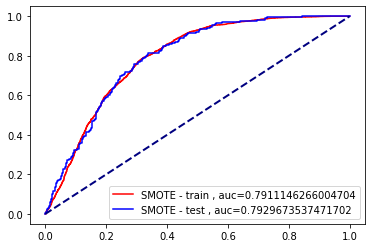

In [85]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [86]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 0.00477493  0.13874711  0.00314878  0.00286403 -0.0019109 ]] [-3.1418781]


In [87]:
X_test

,recency,frequency,monetary_value,tenure,length_of_stay
5546,28.0,7,286,703.0,675.0
3027,158.0,12,839,677.0,519.0
6234,90.0,6,336,641.0,551.0
4308,19.0,9,581,665.0,646.0
3035,25.0,11,678,681.0,656.0
...,...,...,...,...,...
2266,97.0,10,749,672.0,575.0
1303,42.0,13,934,686.0,644.0
474,74.0,4,322,511.0,437.0
1789,191.0,8,561,721.0,530.0


## **XGBoost**

In [88]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.786159
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.78635
[2]	validation_0-auc:0.790547
[3]	validation_0-auc:0.792071
[4]	validation_0-auc:0.794163
[5]	validation_0-auc:0.79464
[6]	validation_0-auc:0.792239
[7]	validation_0-auc:0.791262
[8]	validation_0-auc:0.794462
[9]	validation_0-auc:0.794798
[10]	validation_0-auc:0.796918
[11]	validation_0-auc:0.797264
[12]	validation_0-auc:0.797758
[13]	validation_0-auc:0.797044
[14]	validation_0-auc:0.79563
[15]	validation_0-auc:0.795121
[16]	validation_0-auc:0.795672
[17]	validation_0-auc:0.796387
Stopping. Best iteration:
[12]	validation_0-auc:0.797758

training set
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       429
           1       0.72      0.84      0.78       429

    accuracy                           0.76       858
   macro avg       0.76      0.76      0.75       858
weighted avg       0

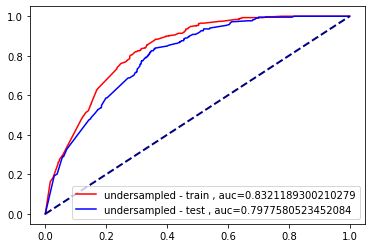

In [89]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

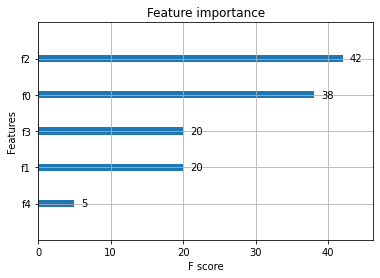

In [90]:
xgb.plot_importance(xgb_model_under)

In [91]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.790217
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.791965
[2]	validation_0-auc:0.795612
[3]	validation_0-auc:0.796281
[4]	validation_0-auc:0.796797
[5]	validation_0-auc:0.798256
[6]	validation_0-auc:0.801869
[7]	validation_0-auc:0.800188
[8]	validation_0-auc:0.803234
[9]	validation_0-auc:0.802747
[10]	validation_0-auc:0.802476
[11]	validation_0-auc:0.803054
[12]	validation_0-auc:0.802267
[13]	validation_0-auc:0.802556
Stopping. Best iteration:
[8]	validation_0-auc:0.803234

training set
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      4389
           1       0.71      0.85      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.75      8778
weighted avg       0.76      0.75      0.75      8778

test set
              precision    recall  f1-score   support

           0       0.97 

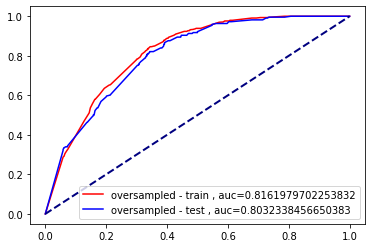

In [92]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

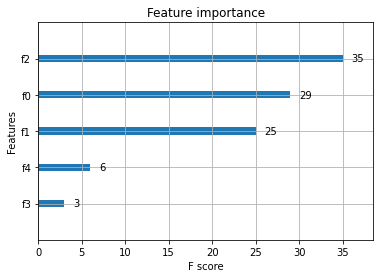

In [93]:
xgb.plot_importance(xgb_model_over)

In [94]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.772959
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.777883
[2]	validation_0-auc:0.791284
[3]	validation_0-auc:0.788195
[4]	validation_0-auc:0.792225
[5]	validation_0-auc:0.794024
[6]	validation_0-auc:0.792863
[7]	validation_0-auc:0.791893
[8]	validation_0-auc:0.792117
[9]	validation_0-auc:0.793376
[10]	validation_0-auc:0.80336
[11]	validation_0-auc:0.803842
[12]	validation_0-auc:0.799962
[13]	validation_0-auc:0.800265
[14]	validation_0-auc:0.80427
[15]	validation_0-auc:0.804465
[16]	validation_0-auc:0.801392
[17]	validation_0-auc:0.801371
[18]	validation_0-auc:0.801747
[19]	validation_0-auc:0.80069
[20]	validation_0-auc:0.801563
Stopping. Best iteration:
[15]	validation_0-auc:0.804465

training set
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      4389
           1       0.77      0.87      0.82      4389

    accuracy                           0.8

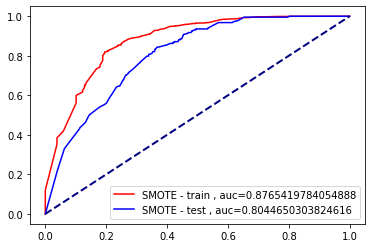

In [95]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

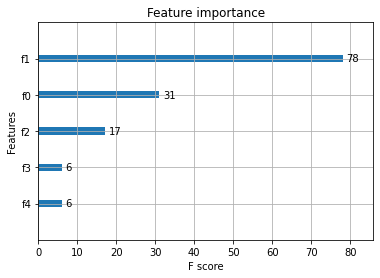

In [96]:
xgb.plot_importance(xgb_model_SMOTE)

In [97]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.734202
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.769773
[2]	validation_0-auc:0.78653
[3]	validation_0-auc:0.780301
[4]	validation_0-auc:0.774851
[5]	validation_0-auc:0.766401
[6]	validation_0-auc:0.772215
[7]	validation_0-auc:0.763176
Stopping. Best iteration:
[2]	validation_0-auc:0.78653

training set
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      4389
           1       0.79      0.84      0.81      4389

    accuracy                           0.81      8778
   macro avg       0.81      0.81      0.81      8778
weighted avg       0.81      0.81      0.81      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      1848
           1       0.24      0.63      0.35       218

    accuracy                           0.75      2066
   macro avg       0.59      0.70 